In [1]:
# dependencias a utilizar
import numpy as np
import matplotlib.pyplot as plt

## Entropy in the microcanonical ensemble (1D harmonic oscillator case)

Consider a 1D harmonic oscillator with mass $m$ and frequency $\omega$. The Hamiltonian is:

$$
H = \frac{p^2}{2m} + \frac{1}{2}m \omega^2 x^2 , \\ \omega = \sqrt{\frac{k}{m}}
$$

- The energy $E$ is conserved, and the phase space trajectory is an ellipse.
- The area of the ellipse in phase space is $A = 2\pi E/\omega$.
- The number of microstates $\Omega(E)$ is proportional to the area $A$, so $\Omega(E) = A/h$, where $h$ is Planck's constant.
- The entropy $S$ is given by $S = k_B \ln(\Omega(E)) = k_B \ln\left(\frac{2\pi E}{h \omega}\right)$.


Omega analytic: 15.707963267948966


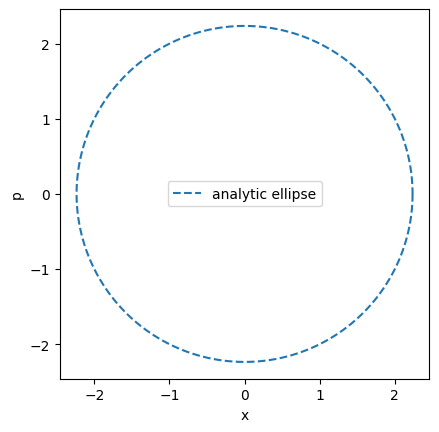

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters (dimensionless)
m = 1.0 # mass
k = 1.0 # spring constant
omega = np.sqrt(k/m) # angular frequency
kB = 1.0 # Boltzmann constant
h = 1.0 # Planck constant

E = 2.5 # energy
A = np.sqrt(2*E/k) # amplitude
T = 2*np.pi/omega # period

Omega_analytic = 2 * np.pi * E / (h * omega) # phase space area
S_analytic = kB * np.log(Omega_analytic / h) # entropy

print("Omega analytic:", Omega_analytic)

# Plot
plt.figure()
thetas = np.linspace(0,2*np.pi,400)
x_ell = A * np.cos(thetas)
p_ell = - m * omega * A * np.sin(thetas)
plt.plot(x_ell, p_ell, '--', label='analytic ellipse')
plt.gca().set_aspect('equal', 'box')
plt.xlabel('x'); plt.ylabel('p'); plt.legend(); plt.show()

Now we are going to obtain entropy numerically from a dynamic simulation!

In [3]:
from potentials import * # import potentials
from walker import Trajectory1D # import trajectory class to perform MD simulations

load the harmonic potential with spring constant k=1.0 and equilibrium position x0=0.0

In [4]:
pot2 = create_potential("Harmonic", k=1.0, x0=0.0) 

Set the dynamics parameters eg. mass of the particle, step size, number of step, initial position, velocity and integrator
Due we want to reproduce the entropy with an Energy value of 2.5 compute the initial position necessary to obtain this energy assuming v initial = 0 (consider you will start from a system with kinetic energy = 0) and the potentia energy is $U(x) = k(x-0)^{2}$ 

In [5]:
traj = Trajectory1D(potential=pot2, m=1.0, dt=0.02, steps=200, x0=np.sqrt(5), v0=0.0, integrator="velocity_verlet")

run the simulation!!

In [6]:
traj.run()

now the traj object finished the simulation process and you can extract information of its methods

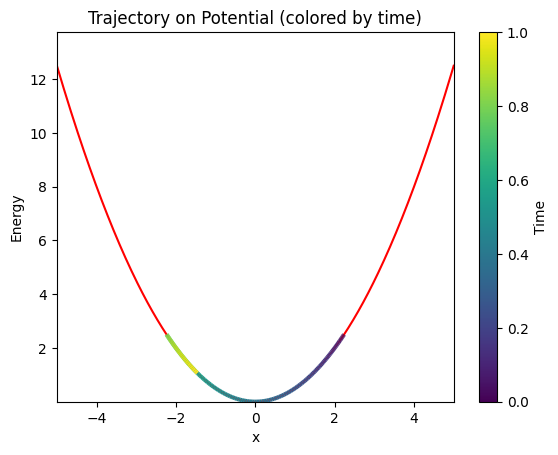

In [7]:
traj.plot_on_potential(xmin=-5, xmax=5)

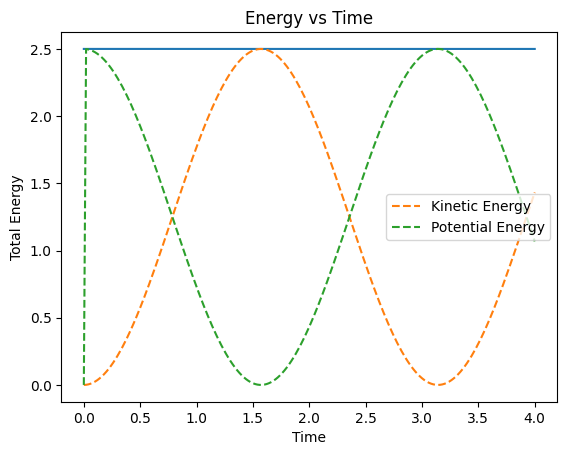

In [8]:
traj.plot_energy()

In [9]:
# Compute area in phase space using traj.x and traj.v (one period)
x_traj = traj.x
v_traj = traj.v

# Compute momentum
p_traj = m * v_traj
dt = traj.dt

# Find one cycle (x crossing x0 with positive v)
#x_cycle = x_traj[0:(T/dt).astype(int)+1]

# Use one period (assume length of x_cycle is one period)
N_period = int(T/dt) + 1 
x_period = x_traj[:N_period] 
p_period = p_traj[:N_period]

# Shoelace formula for area
area_traj = 0.5 * np.abs(np.dot(x_period, np.roll(p_period, -1)) - np.dot(p_period, np.roll(x_period, -1))) # area from numerical trajectory

# Numerical entropy
S_traj = kB * np.log(area_traj / h)
print("Area from traj.x and traj.v:", area_traj)
print("Numerical entropy from traj:", S_traj)

Area from traj.x and traj.v: 11.891020571446774
Numerical entropy from traj: 2.475783541455356


In [10]:
S_traj, S_analytic

(2.475783541455356, 2.7541677982835004)

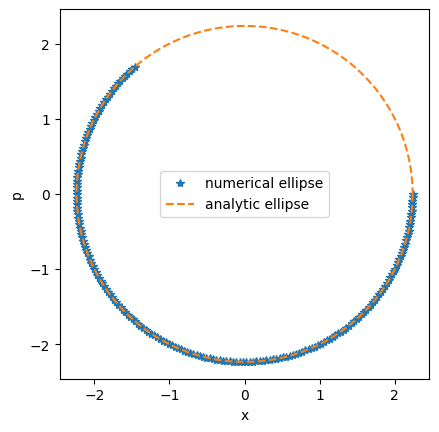

In [11]:
plt.plot(x_period, p_period,'*', label='numerical ellipse')
plt.plot(x_ell, p_ell, '--', label='analytic ellipse')
plt.gca().set_aspect('equal', 'box')
plt.xlabel('x'); plt.ylabel('p'); plt.legend(); plt.show()

How the entropy behaves when multiple cycle are completed during the simulation ?

In [44]:
# Compute area in phase space using traj.x and traj.v (multiple periods averaged)
x_traj = traj.x
v_traj = traj.v
dt     = traj.dt

# Compute momentum
p_traj = m * v_traj

# Define one period length in steps
N_period = int((T/dt).astype(int))   # number of steps in one cycle

# Function: shoelace area for one closed loop
def shoelace_area(x, p):
    return 0.5 * np.abs(np.dot(x, np.roll(p, -1)) - np.dot(p, np.roll(x, -1)))

# Split trajectory into consecutive periods
areas = []
n_cycles = len(x_traj) // N_period
for i in range(n_cycles):
    start = i * N_period
    end   = (i+1) * N_period
    x_cycle = x_traj[start:end]
    p_cycle = p_traj[start:end]
    if len(x_cycle) > 1:  # avoid empty slice at the end
        areas.append(shoelace_area(x_cycle, p_cycle))

areas = np.array(areas)

# Average area and entropy
area_mean = np.mean(areas)
area_std  = np.std(areas)
S_mean    = kB * np.log(area_mean / h)

print("Areas from individual cycles:", areas)
print("Mean area:", area_mean, "±", area_std)
print("Numerical entropy (mean):", S_mean)


Areas from individual cycles: []
Mean area: nan ± nan
Numerical entropy (mean): nan


/home/ccastillo/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ccastillo/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ccastillo/.local/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ccastillo/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ccastillo/.local/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [45]:
S_traj, S_analytic, S_mean
np.abs(S_mean - S_analytic)

nan

## HANDS-ON ACTIVITY
1. change the step size dt and see how it affects the numerical entropy
2. change the number of steps to see how it affects the numerical entropy
3. change the initial condition (x0, v0) to see how it affects the numerical entropy
